In [ ]:
!pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 895.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 931.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from facenet_pytorch import InceptionResnetV1
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
import pandas as pd


In [1]:
import os
import gdown
import zipfile

# Create a folder to store the dataset
os.makedirs("celeba", exist_ok=True)

# Download the CelebA dataset using the gdown library
# This is the Google Drive link to the aligned images (around 1.3GB)
celeba_url = "https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM"
celeba_zip = "celeba/img_align_celeba.zip"

# Download the zip file
gdown.download(celeba_url, celeba_zip, quiet=False)

# Extract the images
with zipfile.ZipFile(celeba_zip, 'r') as zip_ref:
    zip_ref.extractall("celeba/")

print("CelebA dataset downloaded and extracted!")


Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=d86854cc-edb0-488f-abd7-8c5cbc6694bb
To: /content/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:12<00:00, 119MB/s]


CelebA dataset downloaded and extracted!


In [2]:
# List the contents of the CelebA directory
os.listdir("celeba/img_align_celeba")[:10]  # Display the first 10 images


['186168.jpg',
 '096339.jpg',
 '000360.jpg',
 '041000.jpg',
 '158286.jpg',
 '072445.jpg',
 '156355.jpg',
 '036299.jpg',
 '092062.jpg',
 '050952.jpg']

In [69]:
# Download attribute and split files
attr_url = "https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U"
split_url = "https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ"

gdown.download(attr_url, "celeba/list_attr_celeba.txt", quiet=False)
gdown.download(split_url, "celeba/list_eval_partition.txt", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 93.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /content/celeba/list_eval_partition.txt
100%|██████████| 12.2M/12.2M [00:00<00:00, 148MB/s]


'celeba/list_eval_partition.txt'

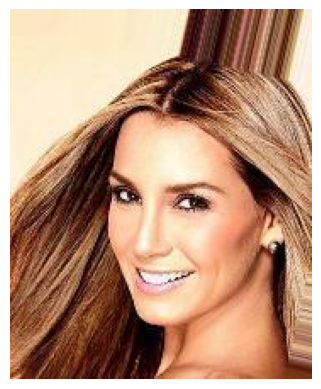

In [70]:
import cv2
import matplotlib.pyplot as plt

# Load a sample image
img = cv2.imread('celeba/img_align_celeba/000001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


In [91]:
import pandas as pd

attributes = pd.read_csv('celeba/list_attr_celeba.txt', sep='\s+', skiprows=1, on_bad_lines='warn')
landmarks = pd.read_csv('celeba/list_eval_partition.txt', sep='\s+', skiprows=1, on_bad_lines='warn')

print("Attributes shape:", attributes.shape)
print("Landmarks shape:", landmarks.shape)


Attributes shape: (202599, 40)
Landmarks shape: (202599, 10)


In [92]:
def reset_dim(df):
    df_reset = df.reset_index()
    df_reset.rename(columns={'index': 'filename'}, inplace=True)
    return df_reset

attributes_new = reset_dim(attributes)
landmarks_new = reset_dim(landmarks)


In [93]:
attributes_new.shape, landmarks_new.shape

((202599, 41), (202599, 11))

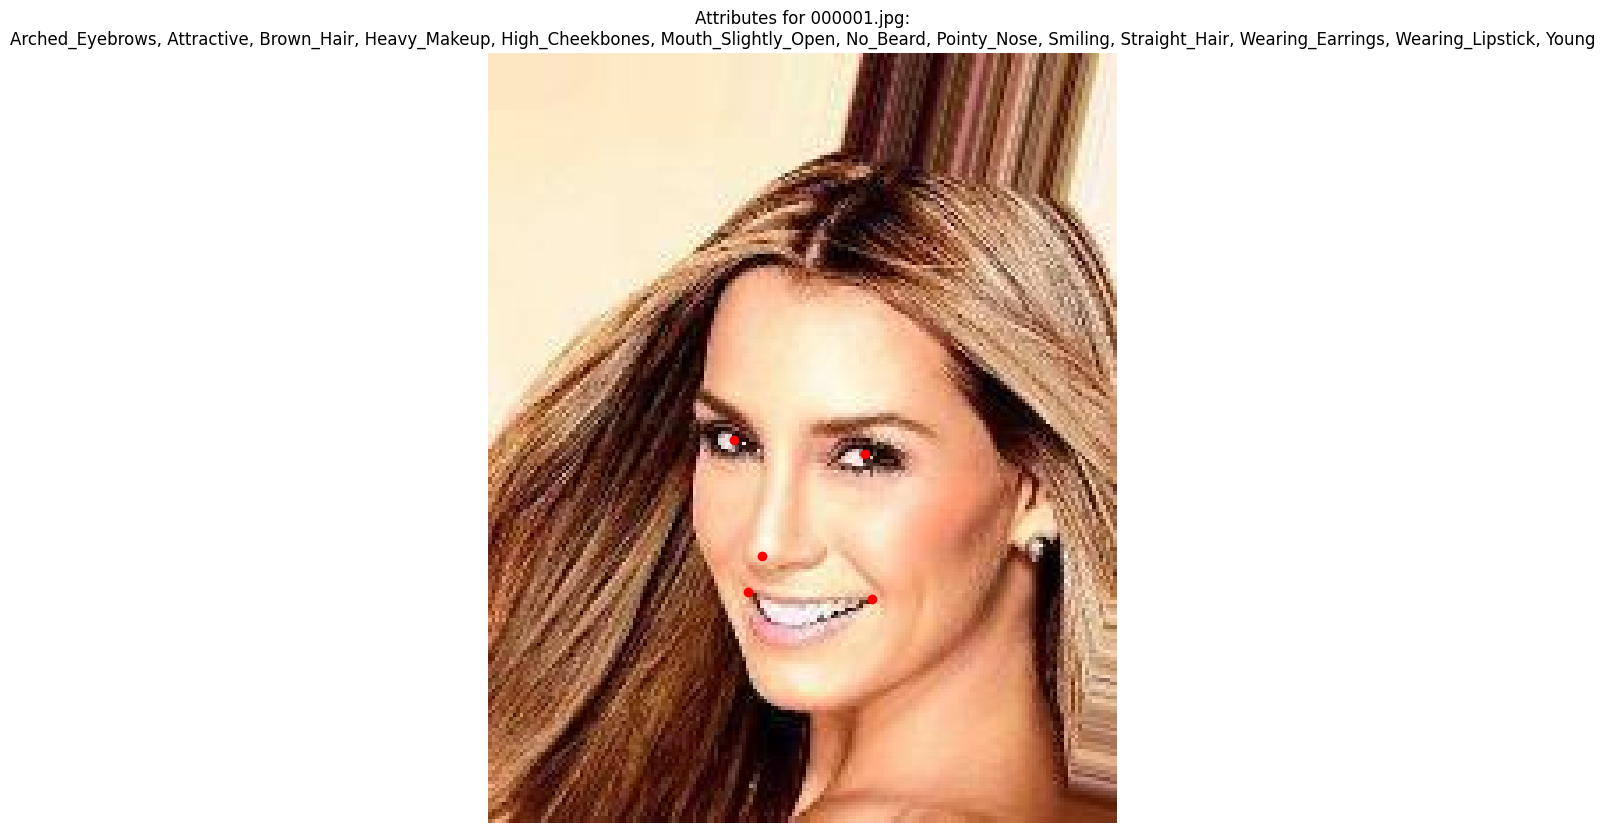

In [94]:
# Define the filename to check
filename = '000001.jpg'

# Access attributes and landmarks for the specified image
attr_row = attributes_new.loc[attributes_new['filename'] == filename].iloc[0,1:] # Selecting the first row (iloc[0]) after filtering by filename and all columns starting from the second one (1:) to exclude filename itself.
landmark_row = landmarks_new.loc[landmarks_new['filename'] == filename].iloc[0,1:] #Selecting the first row (iloc[0]) after filtering by filename and all columns starting from the second one (1:) to exclude filename itself.



# Display the image with landmarks
image_path = f'celeba/img_align_celeba/{filename}'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get landmarks coordinates
landmarks_coords = landmark_row.values.reshape(-1, 2)  # Reshape to pairs of (x, y)

# Plot image and landmarks
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.scatter(landmarks_coords[:, 0], landmarks_coords[:, 1], color='red', marker='o')

# Display attributes in the title
attributes_str = ', '.join(attr_row.index[attr_row.values == 1])
plt.title(f'Attributes for {filename}:\n{attributes_str}')
plt.axis('off')
plt.show()

In [96]:
# Define the target attribute (for binary classification, e.g., Male or Female)
target_attribute = 'Male'  # Change this based on your use case
attributes_new['target'] = attributes_new[target_attribute].apply(lambda x: 1 if x == 1 else 0)


In [97]:
attributes_new['target'].head()

,target
0,0
1,0
2,1
3,0
4,0


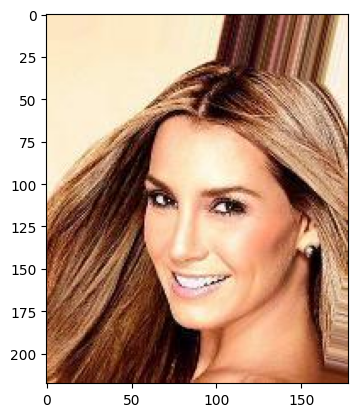

In [100]:
# Display the image with landmarks
filename = '000001.jpg'
image_path = f'celeba/img_align_celeba/{filename}'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [101]:
# Check the shape of the data
print("Attributes shape:", attributes_new.shape)
print("Landmarks shape:", landmarks_new.shape)

Attributes shape: (202599, 42)
Landmarks shape: (202599, 11)


In [102]:
attributes_new.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,target
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,0
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,0
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,0
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,0


In [113]:
# Set the paths for your dataset
IMAGE_DIR = 'celeba/img_align_celeba/'
ATTRIBUTES_FILE = 'celeba/list_attr_celeba.txt'
LANDMARKS_FILE = 'celeba/list_landmarks_align_celeba.txt'

In [103]:
attributes_new.columns[0]

'filename'

In [121]:
def load_images_and_labels(file_names, target_column):
    images = []
    labels = []
    for file_name in tqdm(file_names, desc="Loading images and labels", unit="file"):
        img_path = os.path.join(IMAGE_DIR, file_name)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to load image: {img_path}")
            continue  # Skip to the next image if loading fails

        # Access the target value
        target_value = attributes_new.loc[attributes_new['filename'] == file_name, target_column]
        if target_value.empty:
            print(f"Warning: No target found for {file_name}, skipping.")
            continue  # Skip to the next image if label is missing

        image = cv2.resize(image, (128, 128))
        images.append(image)
        labels.append(target_value.values[0])

    return np.array(images), np.array(labels)

In [115]:
print(attributes_new.columns)

Index(['filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'target'],
      dtype='object')


In [123]:
# Example: Filter images of smiling faces
smiling_faces = attributes_new[attributes_new['Smiling'] == 1]
print(f"Number of smiling faces: {len(smiling_faces)}")

# Get image names of smiling faces
smiling_images = smiling_faces.index.values

Number of smiling faces: 97669


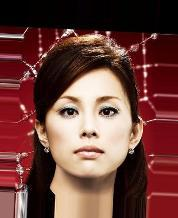

In [133]:
# Align faces based on landmarks (assume landmarks contain 'lefteye_x', 'lefteye_y', etc.)
def align_face(image_path, landmarks):
    image = cv2.imread(image_path)
    # Ensure landmark values are integers:
    left_eye = (int(landmarks['lefteye_x']), int(landmarks['lefteye_y']))
    right_eye = (int(landmarks['righteye_x']), int(landmarks['righteye_y']))

    # Calculate the angle between the eyes
    dx = right_eye[0] - left_eye[0]
    dy = right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(dy, dx))

    # Get the center point between the eyes for rotation
    eye_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    # Rotate the image to align the eyes horizontally
    rotation_matrix = cv2.getRotationMatrix2D(eye_center, angle, scale=1.0)
    aligned_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

    return aligned_image

# Example: Align the first image in the dataset using its landmarks
first_image_path = dataset_images[0]
first_image_name = os.path.basename(first_image_path)
first_image_landmarks = landmarks.loc[first_image_name]  # Get the landmark for the first image
aligned_image = align_face(first_image_path, first_image_landmarks)


from google.colab.patches import cv2_imshow

# Show the aligned image using cv2_imshow
cv2_imshow(aligned_image)


In [ ]:
# Example: Combine embedding with attributes
def combine_embedding_with_attributes(image_path, embedding, attributes):
    # Get attribute values for the image
    image_name = os.path.basename(image_path)
    image_attributes = attributes.loc[image_name].values  # Get attributes as array

    # Combine embedding and attributes
    combined_features = np.concatenate([embedding.flatten(), image_attributes], axis=0)

    return combined_features

# Combine for one image
combined_features = combine_embedding_with_attributes(dataset_images[0], dataset_embeddings[0], attributes)


In [129]:
image_folder = '/content/celeba/img_align_celeba/'
# Load images from the folder
def load_images_from_folder(folder):
    image_paths = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if filename.endswith(".jpg"):  # Ensure only image files are selected
            image_paths.append(img_path)
    return image_paths

# Get the list of image paths
dataset_images = load_images_from_folder(image_folder)
print(f"Total images loaded: {len(dataset_images)}")

Total images loaded: 202599


In [131]:
# Paths to attributes and landmarks
attributes_file = '/content/celeba/list_attr_celeba.txt'
landmarks_file = '/content/celeba/list_eval_partition.txt'

# Load attributes and landmarks
attributes = pd.read_csv(attributes_file, delim_whitespace=True, header=1)
landmarks = pd.read_csv(landmarks_file, delim_whitespace=True, header=1)

# Show first few rows for verification
print(attributes.head())
print(landmarks.head())

<ipython-input-131-696c23d9cf40>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  attributes = pd.read_csv(attributes_file, delim_whitespace=True, header=1)
<ipython-input-131-696c23d9cf40>:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  landmarks = pd.read_csv(landmarks_file, delim_whitespace=True, header=1)


            5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
000001.jpg    -1     -1        -1        -1          -1          -1  ...   
000002.jpg    -1     -1        -1         1          -1          -1  ...   
000003.jpg    -1     -1         1        -1          -1          -1  ...   
000004.jpg    -1     -1        -1        -1          -1          -1  ...   
000005.jpg    -1     -1         1        -1          -1          -1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings